In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)
from scipy.special import sph_harm, spherical_jn, spherical_yn
from math import pi

In [6]:
import diff_tools as dt 
hbar = 1   # unitless


In [7]:
# Graph values of bessel/hankel functions


def sph_hankel(l, k, R):
    return spherical_jn(l, k*R) + 1j * spherical_yn(l, k*R)
def sph_hankel_deriv(l, k, R):
    return spherical_jn(l, k*R, derivative=True) + 1j * spherical_yn(l, k*R, derivative=True)

In [8]:
def Cl(l, k, k_prime, R, delta):
    return (1j**(l+1) * np.sqrt(4 * pi * (2 * l + 1)) * (k * R)**(-2))/\
    (sph_hankel_deriv(l, k, R) * spherical_jn(l, k_prime * R) - np.sqrt(1 + 2 * delta) * sph_hankel(l, k, R) * spherical_jn(l, k_prime * R, derivative=True))

In [9]:
jn = lambda n, z: spherical_jn(n, z)
jd = lambda n, z: spherical_jn(n, z, True)
hn = lambda n, z: spherical_jn(n, z) + 1j * spherical_yn(n, z)
hd = lambda n, z: spherical_jn(n, z, True) + 1j * spherical_yn(n, z, True)


def outside_analytical(l, k, k_prime):
    matrix_plus = [[-hn(l, k), jn(l, k_prime)],
                    [-k * hd(l, k), k_prime * jd(l, k_prime)]]
    vector_plus = [1j ** l * np.sqrt(4 * np.pi * (2 * l + 1)) * jn(l, k),
                    1j ** l * np.sqrt(4 * np.pi * (2 * l + 1)) * k * jd(l, k)]
    
    if np.linalg.det(matrix_plus) == 0:
        print(f'Singular matrix for l={l}, k={k}, k_prime={k_prime}:')
        print(matrix_plus)

    coeff_plus = np.linalg.solve(matrix_plus, vector_plus)
    return coeff_plus[0]

print(np.abs(outside_analytical(10, .1, 1))**2)
print(np.abs(outside_analytical(10, .1, 1000000000))**2)

1.3773908968735007e-83
3.2533189512704212e-78


Asym condition: delta^3/2 kr =  0.005


C:\Users\natha\AppData\Local\Temp\ipykernel_23628\1153266323.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return (1j**(l+1) * np.sqrt(4 * pi * (2 * l + 1)) * (k * R)**(-2))/\
C:\Users\natha\AppData\Local\Temp\ipykernel_23628\1153266323.py:3: RuntimeWarning: invalid value encountered in scalar multiply
  (sph_hankel_deriv(l, k, R) * spherical_jn(l, k_prime * R) - np.sqrt(1 + 2 * delta) * sph_hankel(l, k, R) * spherical_jn(l, k_prime * R, derivative=True))
C:\Users\natha\AppData\Local\Temp\ipykernel_23628\1153266323.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (1j**(l+1) * np.sqrt(4 * pi * (2 * l + 1)) * (k * R)**(-2))/\


Asym condition: delta^3/2 kr =  0.01
Asym condition: delta^3/2 kr =  0.015
Asym condition: delta^3/2 kr =  0.8
Asym condition: delta^3/2 kr =  1.0
Asym condition: delta^3/2 kr =  1.2
Asym condition: delta^3/2 kr =  10.0


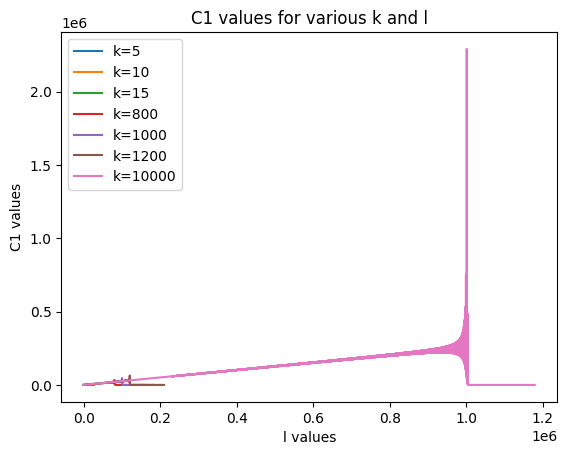

In [33]:
delta = 0.01
R = 1

k_vals = [5, 10, 15, 800, 1000, 1200, 10000]


for k in k_vals:
    k_prime = k * np.sqrt(1 + 2 * delta)
    print("Asym condition: delta^3/2 kr = ", delta**(3/2) * k * R)
    
    C_list = []
    x = np.linspace(0, 10000000, 100000)
    
    for l in range(100000):
        C_list.append(np.abs(Cl(l, k, k_prime, R, delta))**2)
        
    plt.plot(x, C_list, label="k="+str(k))
    
plt.xlabel('l values')  
plt.ylabel('C1 values')
plt.legend()
plt.title('C1 values for various k and l')

plt.show()

Asym condition: delta^3/2 kr =  0.01
Asym condition: delta^3/2 kr =  0.02
Asym condition: delta^3/2 kr =  0.6


C:\Users\natha\AppData\Local\Temp\ipykernel_23628\1153266323.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return (1j**(l+1) * np.sqrt(4 * pi * (2 * l + 1)) * (k * R)**(-2))/\
C:\Users\natha\AppData\Local\Temp\ipykernel_23628\1153266323.py:3: RuntimeWarning: invalid value encountered in scalar multiply
  (sph_hankel_deriv(l, k, R) * spherical_jn(l, k_prime * R) - np.sqrt(1 + 2 * delta) * sph_hankel(l, k, R) * spherical_jn(l, k_prime * R, derivative=True))
C:\Users\natha\AppData\Local\Temp\ipykernel_23628\1153266323.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (1j**(l+1) * np.sqrt(4 * pi * (2 * l + 1)) * (k * R)**(-2))/\


Asym condition: delta^3/2 kr =  1.6
Asym condition: delta^3/2 kr =  2.0


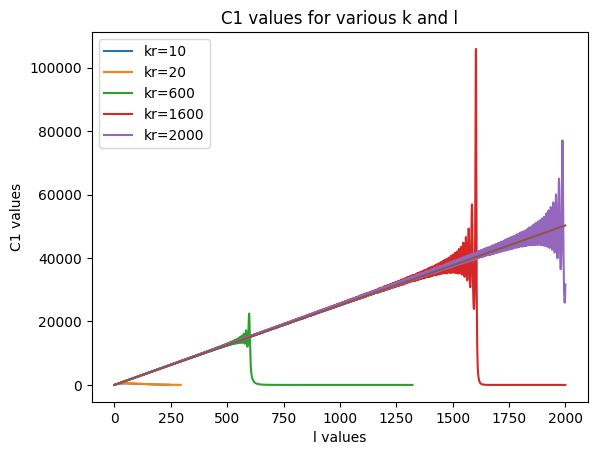

In [34]:
delta = 0.01
R = 2

k_vals = [5, 10, 300, 800, 1000]



for k in k_vals:
    k_prime = k * np.sqrt(1 + 2 * delta)
    print("Asym condition: delta^3/2 kr = ", delta**(3/2) * k * R)
    
    C_list = []
    x = np.linspace(0, 2000, 2000)
    
    for l in range(2000):
        C_list.append(np.abs(Cl(l, k, k_prime, R, delta))**2)
        
    plt.plot(x, C_list, label="kr="+str(k * R))

plt.plot(x, 4*pi*2*x)    
plt.xlabel('l values')  
plt.ylabel('C1 values')
plt.legend()
plt.title('C1 values for various k and l')

plt.show()

# C1 goes to zero at l = kr

In [40]:
def harmonic_sum(N, l_max, increment, target_E):
    
    global r_values, psi_antinu, psi_nu
    
    r_values = np.linspace(0.000001, dt.distance, N)
    lowest_eigenval = False
    kr = np.sqrt(target_E) * dt.R
    l_max = int(kr)
    print("kr", kr)
    
    delta = (dt.m * dt.U) / (target_E)
    print("delta", delta)
    print("delta^3/2 * kR:", delta**(3/2) * np.sqrt(target_E) * dt.R)

    

    # Initialize sum arrays
    sum_psi_nu = np.zeros_like(r_values)
    sum_psi_antinu = np.zeros_like(r_values)

    for l in range(0, int(l_max), increment):  # loop over l values in a given increment
        print(f'{(l_max - l)/increment} l values remaining')
        E_pos, psi_nu = np.linalg.eigh(dt.Hamiltonian_nu_25(N, r_values, l))
        E_neg, psi_antinu = np.linalg.eigh(dt.Hamiltonian_antinu_25(N, r_values, l))
        
        psi_nu = psi_nu.T
        psi_antinu = psi_antinu.T
        # sum_psi_nu += psi_nu[n-1]
        # sum_psi_antinu += psi_antinu[n-1]
        #print("E_pos", E_pos)
        
        # Filter the eigenvalues, only adding the one for each l value closest to 1E-8
        min_diff_nu = np.inf
        min_diff_antinu = np.inf
        closest_psi_nu = None
        closest_psi_antinu = None

        for i, E in enumerate(E_pos):
            if .8*target_E < E < 1.2*target_E:
                diff = abs(E - target_E)
                if diff < min_diff_nu:
                    min_diff_nu = diff
                    closest_psi_nu = psi_nu[i]
                    closest_E_nu = E
                   

        for i, E in enumerate(E_neg):
            if .8*target_E < E < 1.2*target_E:
                diff = abs(E - target_E)
                if diff < min_diff_antinu:
                    min_diff_antinu = diff
                    closest_psi_antinu = psi_antinu[i]
                    closest_E_antinu = E
                    
        # going to just add a 1/l^2 factor to the sum_psi_nu and sum_psi_antinu to see how that looks
        # Now I'm gonna add the sph_harm dependence
        if closest_psi_nu is not None and closest_psi_antinu is not None:
            sum_psi_nu += (closest_psi_nu)/(l**2 + 1)
            print(f'neutrinos: l = {l}, E = {closest_E_nu}')
            sum_psi_antinu += (closest_psi_antinu)/(l**2 + 1)
            print(f'antineutrinos: l = {l}, E = {closest_E_antinu}')
        
        if E_pos[0] > 1.2 * target_E and E_neg[0] > 1.2 * target_E and lowest_eigenval == False:
            print(f"lowest nu eigenvalue is {E_pos[0]}\n lowest antinu eigenvalue is {E_neg[0]}")
            lowest_eigenval = True
            

        

    sum_psi_nu_normalized = dt.normalize(sum_psi_nu)
    sum_psi_antinu_normalized = dt.normalize(sum_psi_antinu)

    print(np.sum(np.abs(sum_psi_antinu_normalized)**2))
    print(np.sum(np.abs(sum_psi_nu_normalized)**2))
    

    return sum_psi_nu_normalized, sum_psi_antinu_normalized, N, l_max, increment, target_E



In [32]:
def harmonic_sum_graphing(sum_psi_nu_normalized, sum_psi_antinu_normalized, r_values, N, l_max, increment, target_E):
    asym_normalized = []
    asym_over_delta = []
    delta = (dt.m * dt.U) / (target_E)
    transformed_r_values = (r_values - dt.R) / (delta * dt.R)
    print("delta", delta)
    print("delta^3/2 * kR:", delta**(3/2) * np.sqrt(target_E) * dt.R)

    # Create three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))

    # Plot the sum of the normalized wavefunctions
    ax1.plot(r_values, np.abs(sum_psi_nu_normalized / r_values)**2, color='blue', label='Sum for neutrinos')
    ax1.plot(r_values, np.abs(sum_psi_antinu_normalized / r_values)**2, color='red', label='Sum for antineutrinos', ls = '--')

    # Plot the asymmetry
    for j in range(len(r_values)):
        asym_over_delta.append((np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 - np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2) / delta)
        if np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 == np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2 and np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 == 0:
            asym_normalized.append(0)
        else:
            asym_normalized.append((np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 - np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2) / (np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 + np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2))
    
    ax2.plot(r_values, asym_normalized, label=f'Asymmetry: N = {N}') # graphing numerically
    ax3.plot(transformed_r_values, asym_over_delta, label=f'Asymmetry over delta: N = {N}') # graphing numerically

    # Set labels and title for the first subplot
    ax1.set_xlabel('r (1/ev)')
    ax1.set_ylabel(r'$\mid\psi\mid^2$', fontsize=15)
    ax1.set_yscale('log')
    ax1.set_xscale('linear')
    ax1.set_title(f'Sum of k^2 ~ {target_E} for r = {dt.R}, \nfirst {l_max} l values, increment of {increment}')
    ax1.axvline(x=dt.R, color='red', linestyle='--', linewidth=1)  # Add vertical line at x = R

    # Set labels and title for the second subplot
    ax2.set_xlabel('r (1/ev)')
    ax2.set_ylabel(r'$\frac{\psi_\nu^2 - \psi_{\overline{\nu}}^2}{\psi_\nu^2 + \psi_{\overline{\nu}}^2}$', fontsize=15)
    ax2.set_yscale('linear')
    ax2.set_xscale('linear')    
    ax2.set_title(f'Asymmetry for Sum of k^2 ~ {target_E} \nfor first {l_max} l values')
    ax2.axvline(x=dt.R, color='red', linestyle='--', linewidth=1)  # Add vertical line at x = R

    ax3.set_xlabel(r'$(r - R)/(\delta \cdot R)$')
    ax3.set_ylabel(r'$\frac{\psi_\nu^2 - \psi_{\overline{\nu}}^2}{\delta}$', fontsize=15)
    ax3.set_yscale('linear')
    ax3.set_xscale('linear')
    ax3.set_title(f'Asymmetry over delta for Sum of k^2 ~ {target_E} \nfor first {l_max} l values')
    ax3.axvline(x=0, color='red', linestyle='--', linewidth=1)  # Add vertical line at x = 0

    # Display legend
    ax1.legend()
    ax2.legend()
    ax3.legend()

    plt.savefig('1D_plots/sum_function.png')
    plt.show()

    fig, (ax5, ax4) = plt.subplots(1, 2, figsize=(18, 6))

    ax5.plot(r_values, asym_normalized, label=f'Asymmetry: N = {N}') # graphing numerically
    ax5.set_xlabel('r (1/ev)')
    ax5.set_ylabel(r'$\frac{\psi_\nu^2 - \psi_{\overline{\nu}}^2}{\psi_\nu^2 + \psi_{\overline{\nu}}^2}$', fontsize=15)
    ax5.set_yscale('linear')
    ax5.set_xscale('linear')    
    ax5.set_title(f'Zoomed Asymmetry around R = {dt.R}')
    ax5.axvline(x=dt.R, color='red', linestyle='--', linewidth=1)  # Add vertical line at x = R
    ax5.set_xlim(.8 * dt.R, 1.2 * dt.R)


    ax4.plot(transformed_r_values, asym_over_delta, label=f'Asymmetry over delta: N = {N}')
    ax4.set_xlabel(r'$(r - R)/(\delta \cdot R)$')
    ax4.set_ylabel(r'$\frac{\psi_\nu^2 - \psi_{\overline{\nu}}^2}{\delta}$', fontsize=14)  # Increase font size
    ax4.set_yscale('linear')
    ax4.set_xscale('linear')
    ax4.set_title(f'Zoomed Asymmetry over delta around R = {dt.R}')
    zoom_range = transformed_r_values[-1] - transformed_r_values[0]
    ax4.set_xlim(-0.1 * zoom_range, 0.1 * zoom_range)
    ax4.set_ylim(-.2E-2, .2E-2)
    ax4.axvline(x=0, color='red', linestyle='--', linewidth=1)  # Add vertical line at x = 0

    # Display legend
    ax4.legend()
    ax5.legend()

    plt.savefig('1D_plots/zoomed_asymmetry_over_delta.png')
    plt.show()

In [43]:
#graph each value of psi_l at a fixed r with l on the x axis psi**2 on the y axis
# this has to be decreasing in order for it to make sense
# first use the analytical solution given in equation 14
# Have that done - put them on the same graph?


psi_nu_normalized, psi_antinu_normalized, N, l_max, increment, target_E = harmonic_sum(1000, 110, 1, 30)

kr 164.31676725154983
delta 33.333333333333336
delta^3/2 * kR: 31622.776601683796
164.0 l values remaining
neutrinos: l = 0, E = 29.988001697078555
antineutrinos: l = 0, E = 29.98905967429412
163.0 l values remaining
neutrinos: l = 1, E = 29.988320437440457
antineutrinos: l = 1, E = 29.989378397519626
162.0 l values remaining
neutrinos: l = 2, E = 29.988957922597173
antineutrinos: l = 2, E = 29.990015848395903
161.0 l values remaining
neutrinos: l = 3, E = 29.989914161416515
antineutrinos: l = 3, E = 29.990972035775428
160.0 l values remaining
neutrinos: l = 4, E = 29.99118916720517
antineutrinos: l = 4, E = 29.992246972941906
159.0 l values remaining
neutrinos: l = 5, E = 29.99278295771469
antineutrinos: l = 5, E = 29.99384067761624
158.0 l values remaining
neutrinos: l = 6, E = 29.994695555149463
antineutrinos: l = 6, E = 29.99575317196445
157.0 l values remaining
neutrinos: l = 7, E = 29.99692698617668
antineutrinos: l = 7, E = 29.997984482607713
156.0 l values remaining
neutrinos: 

delta 33.333333333333336
delta^3/2 * kR: 31622.776601683796


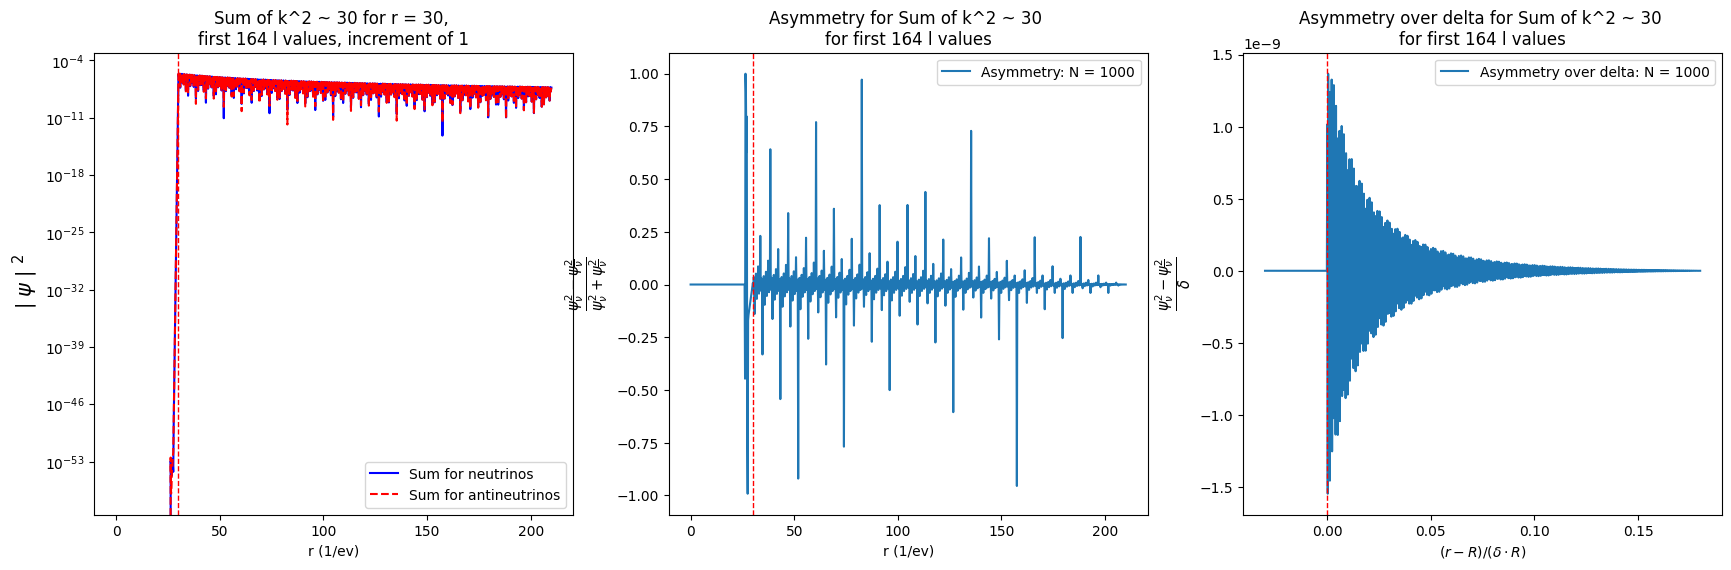

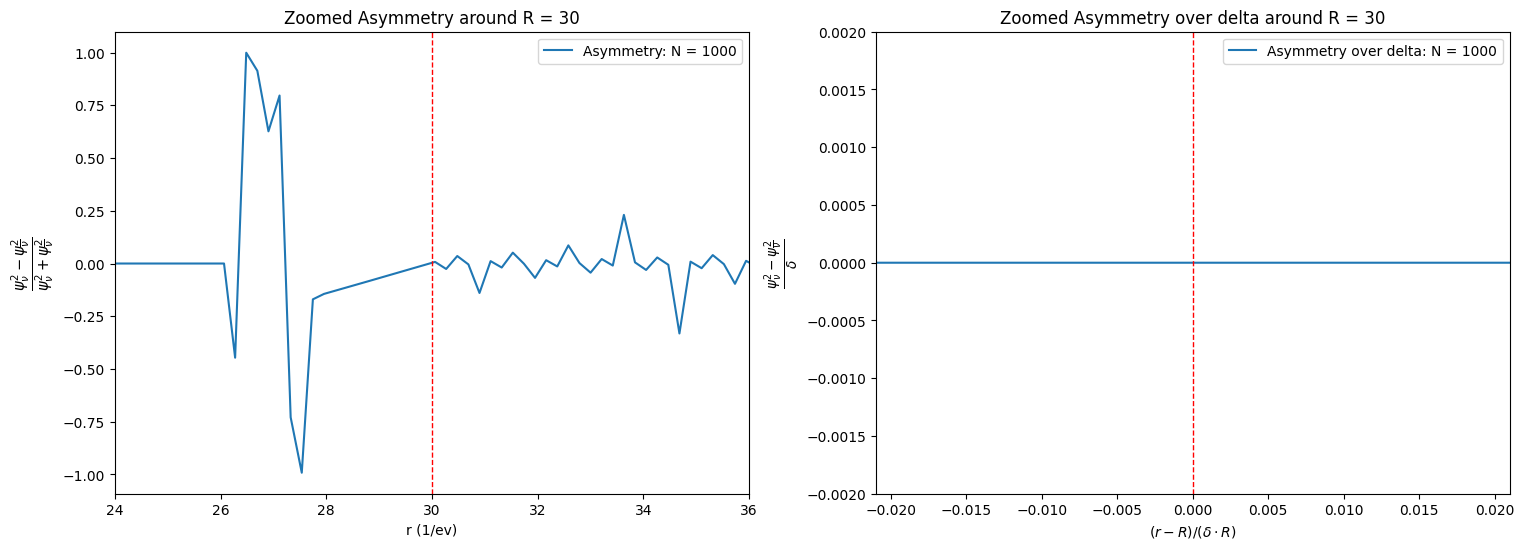

In [44]:
harmonic_sum_graphing(psi_nu_normalized, psi_antinu_normalized, r_values, N, l_max, increment, target_E)

In [3]:
def fixed_R(N, target_E, radius, l_max):
    kR = np.sqrt(target_E) * dt.R
    r_values = np.linspace(.000001, dt.distance, N)
    # l_values = np.linspace(0, 300, N)
    l_values = np.logspace(np.log10(1), np.log10(l_max), N)
    


    # find the index of the r value closest to radius
    r_index = int(np.argmin(np.abs(r_values - radius)))

    lowest_eigenval = False




    # Initialize sum arrays
    values_nu = []
    values_antinu = []

    for i, l in enumerate(l_values):  # loop over l values in a given increment
        print(f'{len(l_values) - i} l values remaining, l = {l}')
        E_pos, psi_nu = np.linalg.eigh(dt.Hamiltonian_nu_25(N, r_values, l))
        E_neg, psi_antinu = np.linalg.eigh(dt.Hamiltonian_antinu_25(N, r_values, l))

        psi_nu = psi_nu.T
        psi_antinu = psi_antinu.T

        # Filter the eigenvalues, only adding the one for each l value closest to 1E-8
        min_diff_nu = np.inf
        min_diff_antinu = np.inf
        closest_psi_nu = None
        closest_psi_antinu = None

        for i, E in enumerate(E_pos):
            if .85*target_E < E < 1.15*target_E:
                diff = abs(E - target_E)
                if diff < min_diff_nu:
                    min_diff_nu = diff
                    closest_psi_nu = psi_nu[i]
                    closest_E_nu = E
                    
                

        for i, E in enumerate(E_neg):
            if .85*target_E < E < 1.15*target_E:
                diff = abs(E - target_E)
                if diff < min_diff_antinu:
                    min_diff_antinu = diff
                    closest_psi_antinu = psi_antinu[i]
                    closest_E_antinu = E

        # Having sorted eigenvalues, append the psi value corresponding to the index of the r value closest to our desired radius to our list
        if closest_psi_nu is not None:
            values_nu.append(np.abs(closest_psi_nu[r_index])**2)
        else:
            values_nu.append(0)
            print("none")
        if closest_psi_antinu is not None:
            values_antinu.append(np.abs(closest_psi_antinu[r_index])**2)
        else:
            values_antinu.append(0)
            print("none")


    return values_nu, values_antinu, l_max, N, target_E, radius
    # return values_nu, l_values, N, target_E, radius

In [25]:
def fixed_R_graphing(values_nu, values_antinu, l_max, N, target_E, radius):
    k = np.sqrt(target_E)
    kR = k * dt.R
    delta = dt.m * dt.U / target_E
    k_plus = k * np.sqrt(1 + 2 * delta)
    k_minus = k * np.sqrt(1 - 2 * delta)
    l_values = np.logspace(np.log10(1), np.log10(l_max), N)
    l_values_analytical = np.logspace(np.log10(1), np.log10(10*l_max), 200*N)
    print(values_nu)
    print(values_antinu)

    plt.loglog(l_values, values_nu, label = f'Neutrino values: N = {N}')
    plt.loglog(l_values, values_antinu, label = f'Antineutrino values: N = {N}')
    plt.title(f"psi^2 values for varying l values, target k^2 = {target_E}, radius = {radius}")
    plt.axvline(x=kR, color='red', linestyle='--', linewidth=1)


    asym_normalized = (np.array(values_nu) - np.array(values_antinu)) / (np.array(values_nu) + np.array(values_antinu))
    asym_delta = (np.array(values_nu) - np.array(values_antinu)) / delta
    list_plus = []
    list_minus = []
       

    if radius < dt.R:
        print("inside")
        for l in l_values_analytical:
            list_plus.append(np.abs(Cl(l, k, k_plus, radius, delta) * spherical_jn(l, k_plus * radius))**2 / (4*pi))
            list_minus.append(np.abs(Cl(l, k, k_minus, radius, delta) * spherical_jn(l, k_minus * radius))**2 / (4*pi))
        
        plt.loglog(l_values_analytical, list_plus, label = 'Analytical neutrino values inside')
        plt.loglog(l_values_analytical, list_minus, label = 'Analytical antineutrino values inside')
    else:
        print("outside")
        for l in l_values_analytical:
            try:
                list_plus.append(np.abs(1j**l * np.sqrt(4 * pi * (2 * l +1)) * spherical_jn(l, k * radius) + \
                                outside_analytical(l, k, k_plus) * sph_hankel(l, k, radius))**2 / (4*pi))
            except np.linalg.LinAlgError:
                print(f"Calculation failed at l = {l}, using preceding l values")
                break
        for l in l_values_analytical:
            try:
                list_minus.append(np.abs(1j**l * np.sqrt(4 * pi * (2 * l +1)) * spherical_jn(l, k * radius) + \
                                outside_analytical(l, k, k_minus) * sph_hankel(l, k, radius))**2 / (4*pi))
            except np.linalg.LinAlgError:
                print(f"Calculation failed at l = {l}, using preceding l values")
                break

        plt.loglog(l_values_analytical[:len(list_plus)], list_plus, label = 'Analytical neutrino values outside')
        plt.loglog(l_values_analytical[:len(list_minus)], list_minus, label = 'Analytical antineutrino values outside')
    plt.xlabel("l values")
    plt.ylabel("psi^2")
    plt.ylim(1E-30, 5)
    # plt.xlim(1, 130)
    plt.legend()
    plt.xscale('log')
    plt.show()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    min_len = min(len(list_plus), len(list_minus))

    asym_normalized_analytical = (np.array(list_plus[:min_len]) - np.array(list_minus[:min_len])) / (np.array(list_plus[:min_len]) + np.array(list_minus[:min_len]))
    asym_delta_analytical = (np.array(list_plus[:min_len]) - np.array(list_minus[:min_len])) / delta
    
    ax1.plot(l_values, asym_normalized, label = f'Asymmetry: N = {N}')
    # ax1.plot(l_values_analytical[:min_len], asym_normalized_analytical, label = 'Analytical asymmetry')
    ax1.set_xlabel('l values')
    ax1.set_ylabel(r'$\frac{\psi_\nu^2 - \psi_{\overline{\nu}}^2}{\psi_\nu^2 + \psi_{\overline{\nu}}^2}$', fontsize=15)
    ax1.set_title(f'Asymmetry for psi^2 values at r = {radius}')
    ax1.set_xscale('log')
    ax1.legend()
    ax1.axvline(x=kR, color='red', linestyle='--', linewidth=1)

    ax2.plot(l_values, asym_delta, label = f'Asymmetry over delta: N = {N}')
    # ax2.plot(l_values_analytical[:min_len], asym_delta_analytical, label = 'Analytical asymmetry over delta')
    ax2.set_xlabel('l values')
    ax2.set_ylabel(r'$\frac{\psi_\nu^2 - \psi_{\overline{\nu}}^2}{\delta}$', fontsize=15)
    ax2.set_title(f'Asymmetry over delta for psi^2 values at r = {radius}')
    ax2.legend()
    ax2.set_xscale('log')
    ax2.axvline(x=kR, color='red', linestyle='--', linewidth=1)

    plt.show()
    
    # plt.title("|Cl * jn|^2 at fixed R for different l")
    # 
    # plt.ylabel("|Cl * jn|^2")
    # plt.show()

In [28]:
values_nu, values_antinu, l_max, N, target_E, radius = fixed_R(800, 30, 40, 700)
# values_nu, l_values, N, target_E, radius = fixed_R(700, 1E-2, 100)
# values_antinu = []

800 l values remaining, l = 1.0
799 l values remaining, l = 1.0082328039605266
798 l values remaining, l = 1.0165333869821058
797 l values remaining, l = 1.0249023070764598
796 l values remaining, l = 1.0333401268493119
795 l values remaining, l = 1.041847413538208
794 l values remaining, l = 1.05042473905065
793 l values remaining, l = 1.0590726800025414
792 l values remaining, l = 1.067791817756952
791 l values remaining, l = 1.0765827384631994
790 l values remaining, l = 1.085446033096254
789 l values remaining, l = 1.0943822974964668
788 l values remaining, l = 1.103392132409626
787 l values remaining, l = 1.112476143527342
786 l values remaining, l = 1.1216349415277655
785 l values remaining, l = 1.1308691421166404
784 l values remaining, l = 1.1401793660686959
783 l values remaining, l = 1.149566239269377
782 l values remaining, l = 1.1590303927569217
781 l values remaining, l = 1.1685724627647818
780 l values remaining, l = 1.178193090764394
779 l values remaining, l = 1.1878929

[0.0006807254978514888, 0.0007102854592219562, 0.0007404251946838594, 0.0007711326363522262, 0.000802394765955352, 0.000834197590599738, 0.0008665261184222312, 0.0008993643341707411, 0.0009326951747544553, 0.000966500504818917, 0.0010007610923960643, 0.001035456584697971, 0.001070565484119126, 0.001106065124526749, 0.0011419316479221516, 0.00117813998156607, 0.0012146638156680801, 0.001251475581749985, 0.0012885464318012736, 0.0013258462183533067, 0.0013633434756113515, 0.0014010054017908097, 0.0014387978428144494, 0.0014766852775421999, 0.0015146308047068338, 0.0015525961317516374, 0.0015905415657666922, 0.0016284260067386152, 0.001666206943336104, 0.001703840451467254, 0.0017412811958551105, 0.0017784824348886133, 0.0018153960290189218, 0.0018519724529804374, 0.001888160812126288, 0.0019239088631803425, 0.001959163039716407, 0.0019938684826826445, 0.0020279690763007337, 0.0020614074896756563, 0.002094125224458154, 0.002126062668909939, 0.002157159158722007, 0.0021873530449446816, 0.0

C:\Users\natha\AppData\Local\Temp\ipykernel_20256\3339595264.py:18: RuntimeWarning: invalid value encountered in divide
  asym_normalized = (np.array(values_nu) - np.array(values_antinu)) / (np.array(values_nu) + np.array(values_antinu))


outside
Singular matrix for l=150.00259512180946, k=5.477225575051661, k_prime=1:
[[(-5.124058828341588e-199+1.1845314128077441e+195j), 0.0], [(-7.681013268960471e-197-1.7874535385056543e+197j), 0.0]]
Calculation failed at l = 150.00259512180946, using preceding l values


C:\Users\natha\AppData\Local\Temp\ipykernel_20256\1776681939.py:9: RuntimeWarning: invalid value encountered in scalar multiply
  [-k * hd(l, k), k_prime * jd(l, k_prime)]]


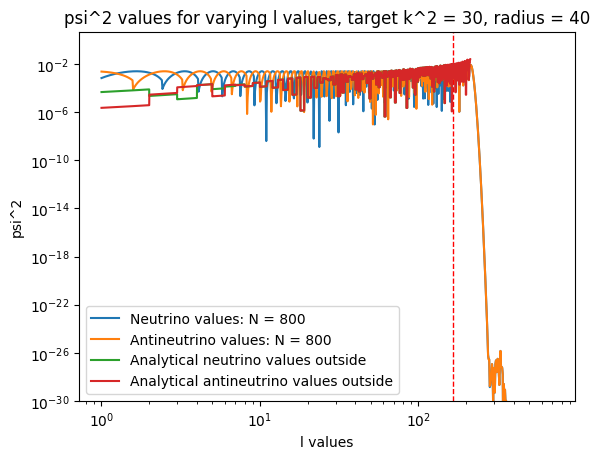

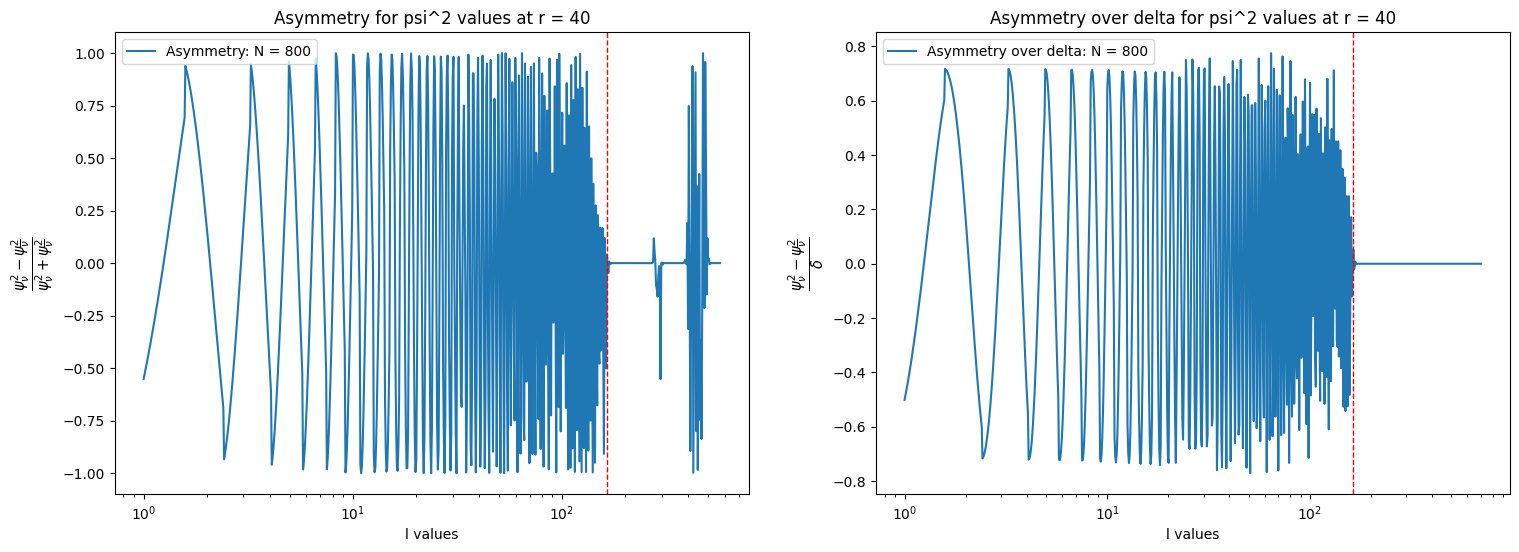

In [29]:
fixed_R_graphing(values_nu, values_antinu, l_max, N, target_E, radius)

C:\Users\natha\AppData\Local\Temp\ipykernel_19244\228121423.py:13: RuntimeWarning: invalid value encountered in divide
  asym_normalized = (np.array(values_nu) - np.array(values_antinu)) / (np.array(values_nu) + np.array(values_antinu))


inside


C:\Users\natha\AppData\Local\Temp\ipykernel_19244\1153266323.py:3: RuntimeWarning: invalid value encountered in scalar multiply
  (sph_hankel_deriv(l, k, R) * spherical_jn(l, k_prime * R) - np.sqrt(1 + 2 * delta) * sph_hankel(l, k, R) * spherical_jn(l, k_prime * R, derivative=True))
C:\Users\natha\AppData\Local\Temp\ipykernel_19244\1153266323.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (1j**(l+1) * np.sqrt(4 * pi * (2 * l + 1)) * (k * R)**(-2))/\


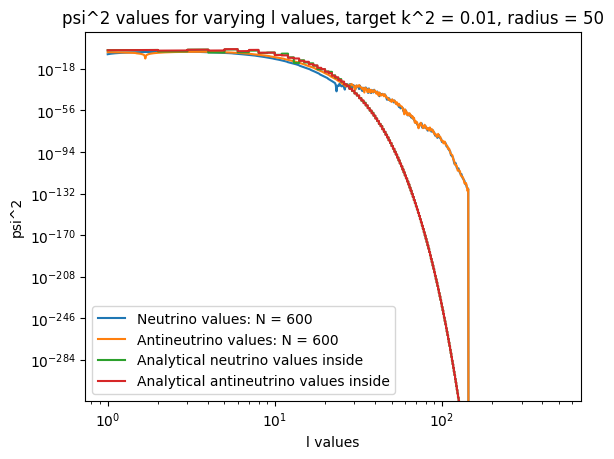

C:\Users\natha\AppData\Local\Temp\ipykernel_19244\228121423.py:56: RuntimeWarning: invalid value encountered in divide
  asym_normalized_analytical = (np.array(list_plus[:min_len]) - np.array(list_minus[:min_len])) / (np.array(list_plus[:min_len]) + np.array(list_minus[:min_len]))


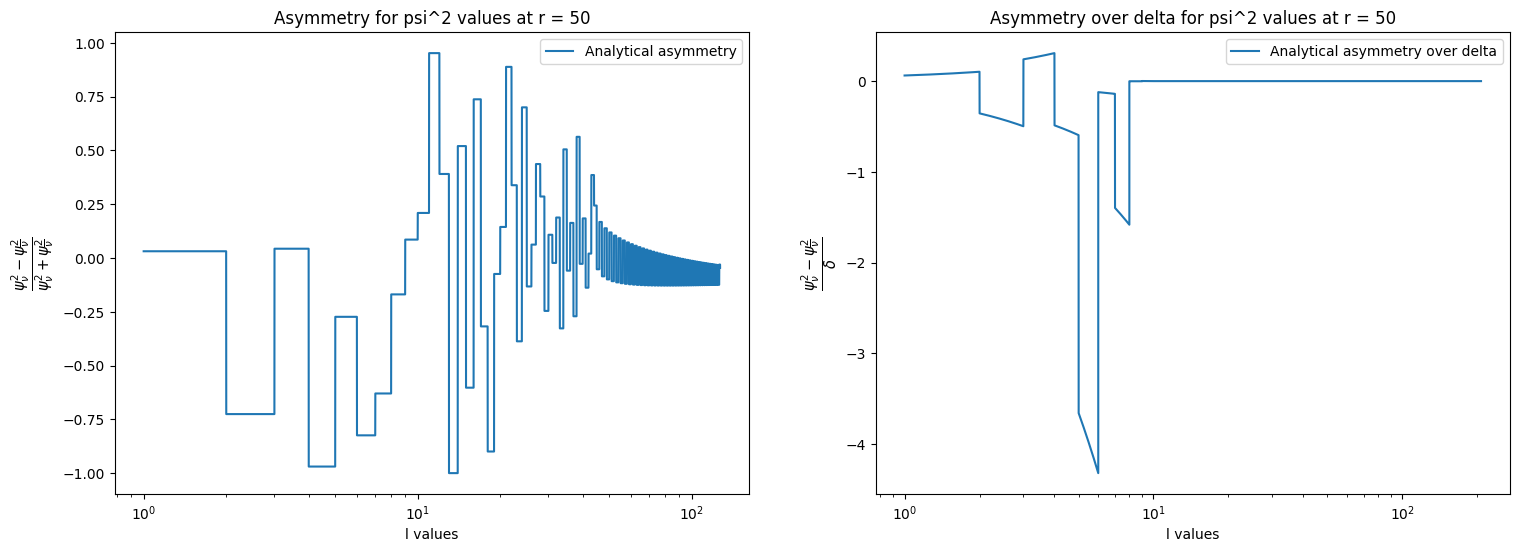

In [250]:
fixed_R_graphing(values_nu, values_antinu, l_max, N, target_E, radius)

In [58]:
def analytic_graph(N, k, l_max, increment):
    delta = dt.m * dt.U / k
    k_plus = k * np.sqrt(1 + 2 * delta)
    k_minus = k * np.sqrt(1 - 2 * delta)
    l_values = np.linspace(0, l_max, int(l_max/increment))
    r_values = np.linspace(0.000001, dt.distance, N)
    values_plus = np.zeros_like(r_values)
    values_minus = np.zeros_like(r_values)
    
   
    for l in l_values:
        print(f'{l_max - l} l values remaining')
        interim_plus_in = []
        interim_minus_in = []
        interim_plus_out = []
        interim_minus_out = []

        for radius in r_values:
            inside_plus = np.abs(Cl(l, k, k_plus, radius, delta) * spherical_jn(l, k_plus * radius))**2 / (4*pi)
            inside_minus = np.abs(Cl(l, k, k_minus, radius, delta) * spherical_jn(l, k_minus * radius))**2 / (4*pi)
            outside_plus = 0# np.abs(1j**l * np.sqrt(4 * pi * (2 * l +1)) * spherical_jn(l, k * radius) + \
                                        #outside_analytical(l, k, k_plus) * sph_hankel(l, k, radius))**2 / (4*pi)
            outside_minus = 0#np.abs(1j**l * np.sqrt(4 * pi * (2 * l +1)) * spherical_jn(l, k * radius) + \
                                        #outside_analytical(l, k, k_minus) * sph_hankel(l, k, radius))**2 / (4*pi)
            if radius < dt.R:
                interim_plus_in.append(inside_plus)
                interim_minus_in.append(inside_minus)
            else:
                interim_plus_out.append(outside_plus)
                interim_minus_out.append(outside_minus)
        interim_plus_in.extend(interim_plus_out)
        interim_minus_in.extend(interim_minus_out)
        values_plus += np.array(interim_plus_in)
        values_minus += np.array(interim_minus_in)
    
    return values_plus, values_minus, r_values, k

In [64]:
def analytic_graphing(values_plus, values_minus, r_values, k):
    asymmetry = []
    for i in range(len(r_values)):
        if values_plus[i] == values_minus[i] and values_plus[i] == 0:
            asymmetry.append(0)
        else: 
            asymmetry.append(values_plus[i] - values_minus[i]) / (values_plus[i] + values_minus[i])
    delta = dt.m * dt.U / k
    asymmetry_delta = (values_plus - values_minus) / delta

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.plot(r_values, asymmetry, label = 'Asymmetry')
    ax1.set_xlabel('r values')
    ax1.set_ylabel(r'$\frac{\psi_\nu^2 - \psi_{\overline{\nu}}^2}{\psi_\nu^2 + \psi_{\overline{\nu}}^2}$', fontsize=15)
    ax1.set_title('Asymmetry for analytical psi^2 values')
    ax1.legend()
    ax1.axvline(x=dt.R, color='red', linestyle='--', linewidth=1)

    ax2.plot(r_values, asymmetry_delta, label = 'Asymmetry over delta')
    ax2.set_xlabel('r values')
    ax2.set_ylabel(r'$\frac{\psi_\nu^2 - \psi_{\overline{\nu}}^2}{\delta}$', fontsize=15)
    ax2.set_title('Asymmetry over delta for analytical psi^2 values')
    ax2.legend()
    ax2.axvline(x=dt.R, color='red', linestyle='--', linewidth=1)

    plt.show()

In [60]:
values_plus, values_minus, r_values, k = analytic_graph(1000, 1, 3E4, 100)

30000.0 l values remaining
29899.665551839465 l values remaining
29799.33110367893 l values remaining
29698.996655518393 l values remaining
29598.66220735786 l values remaining


C:\Users\natha\AppData\Local\Temp\ipykernel_20256\1153266323.py:3: RuntimeWarning: invalid value encountered in scalar multiply
  (sph_hankel_deriv(l, k, R) * spherical_jn(l, k_prime * R) - np.sqrt(1 + 2 * delta) * sph_hankel(l, k, R) * spherical_jn(l, k_prime * R, derivative=True))
C:\Users\natha\AppData\Local\Temp\ipykernel_20256\1153266323.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (1j**(l+1) * np.sqrt(4 * pi * (2 * l + 1)) * (k * R)**(-2))/\


29498.327759197324 l values remaining
29397.99331103679 l values remaining
29297.658862876255 l values remaining
29197.32441471572 l values remaining
29096.989966555186 l values remaining
28996.655518394648 l values remaining
28896.321070234113 l values remaining
28795.98662207358 l values remaining
28695.652173913044 l values remaining
28595.31772575251 l values remaining
28494.983277591975 l values remaining
28394.648829431437 l values remaining
28294.314381270902 l values remaining
28193.979933110368 l values remaining
28093.645484949833 l values remaining
27993.3110367893 l values remaining


C:\Users\natha\AppData\Local\Temp\ipykernel_20256\1153266323.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return (1j**(l+1) * np.sqrt(4 * pi * (2 * l + 1)) * (k * R)**(-2))/\
C:\Users\natha\AppData\Local\Temp\ipykernel_20256\2530613905.py:20: RuntimeWarning: invalid value encountered in scalar multiply
  inside_minus = np.abs(Cl(l, k, k_minus, radius, delta) * spherical_jn(l, k_minus * radius))**2 / (4*pi)


27892.976588628764 l values remaining
27792.642140468226 l values remaining
27692.30769230769 l values remaining
27591.973244147157 l values remaining
27491.638795986622 l values remaining
27391.304347826088 l values remaining
27290.969899665553 l values remaining
27190.635451505015 l values remaining
27090.30100334448 l values remaining
26989.966555183946 l values remaining
26889.63210702341 l values remaining
26789.297658862877 l values remaining
26688.963210702343 l values remaining
26588.628762541804 l values remaining
26488.29431438127 l values remaining
26387.959866220735 l values remaining
26287.6254180602 l values remaining
26187.290969899666 l values remaining
26086.956521739132 l values remaining
25986.622073578597 l values remaining
25886.28762541806 l values remaining
25785.953177257525 l values remaining
25685.61872909699 l values remaining
25585.284280936456 l values remaining
25484.94983277592 l values remaining
25384.615384615383 l values remaining
25284.28093645485 l v

In [65]:
analytic_graphing(values_plus, values_minus, r_values, k)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'